# 개인소득 데이터 + PIR

### 데이터 1(PIR): 월간 KB주택가격동향
- 홈페이지: https://onland.kbstar.com
- 저장 폴더: real_estate_data
- 파일 이름: ★(월간)KB주택가격동향_시계열(2019.09).xlsx

### 데이터 2(개인소득데이터): 국가통계포털 지역별 1인당 개인소득
- 홈페이지: http://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1C65&vw_cd=MT_ZTITLE&list_id=L2_C2010_002&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_ZTITLE
- 저장 폴더: real_estate_data
- 파일 이름: 행정구역_시도_별_1인당_지역내총생산__지역총소득__개인소득_20191003174157.xlsx

In [70]:
import os
import pandas as pd
import xlwings as xw
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

### 함수
- 이름: income_preprocessing
- 목적: 지역별 개인소득 데이터 전처리
- input: path
    - path: 데이터 경로

In [68]:
def income_preprocessing(path):
    raw=pd.read_excel(path,sheet_name='데이터',index_col=0)
    raw.drop(['행정구역(시도)별'],inplace=True)
    index_list=raw.index
    new_index=[]
    for temp in index_list:
        if temp[-1]=='시':
            new_index.append(temp[:2])
        elif temp[-1]=='도':
            if(len(temp)==3):
                new_index.append(temp[:2])
            elif len(temp)==4:
                new_index.append(temp[0]+temp[2])
            else:
                new_index.append('제주')
        else:
            new_index.append(temp)
    col_list=[]
    for col in raw.columns:
        col_list.append(col[0:4])
    raw.columns=col_list
    raw.index=new_index
    return raw.T

In [69]:
incomeData_path=os.getcwd()+'\\real_estate_data\행정구역_시도_별_1인당_지역내총생산__지역총소득__개인소득_20191003174146.xlsx'
income_data=income_preprocessing(incomeData_path)

In [71]:
# 가격지수데이터 불러오기
def KBpriceindex_preprocessing(path,data_type):
    wb=xw.Book(path)
    sheet=wb.sheets[data_type]
    row_num=sheet.range(1,1).end('down').end('down').end('down').row
    data_range='A2:GE'+str(row_num)
    raw_data=sheet[data_range].options(pd.DataFrame, index=False, header=True).value
    
    bignames='서울 대구 부산 대전 광주 인천 울산 세종 경기 강원 충북 충남 전북 전남 경북 경남 제주도 6개광역시 5개광역시 수도권 기타지방 구분 전국'
    bigname_list=bignames.split(' ')
    big_col=list(raw_data.columns)
    small_col=list(raw_data.iloc[0])
    
    for num,gu_data in enumerate(small_col):
        if gu_data==None:
            small_col[num]=big_col[num]
            
        check=num
        while True:
            if big_col[check] in bigname_list:
                big_col[num]=big_col[check]
                break
            else:
                check=check-1;
        
    big_col[129]='경기'
    big_col[130]='경기'
    small_col[185]='서귀포'

    raw_data.columns=[big_col,small_col]
    new_col_data=raw_data.drop([0,1])

    index_list=list(new_col_data['구분']['구분'])

    new_index=[]

    for num, raw_index in enumerate(index_list):
        temp=str(raw_index).split('.')
        if int(temp[0])>12:
            if len(temp[0])==2:
                new_index.append('19'+temp[0]+'.'+temp[1])
            else:
                new_index.append(temp[0]+'.'+temp[1])
        else:
            new_index.append(new_index[num-1].split('.')[0]+'.'+temp[0])

    new_col_data.set_index(pd.to_datetime(new_index),inplace=True)
    cleaned_data=new_col_data.drop(('구분','구분'),axis=1)
    return cleaned_data

In [ ]:
path=os.getcwd()+'\\real_estate_data\★(월간)KB주택가격동향_시계열(2019.09).xlsx'
data_type='매매종합'
price_data=KBpriceindex_preprocessing(path,data_type)

In [74]:
# 데이터 시각화 준비
%matplotlib inline
font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font',family=font_name)
plt.rcParams['axes.unicode_minus']=False

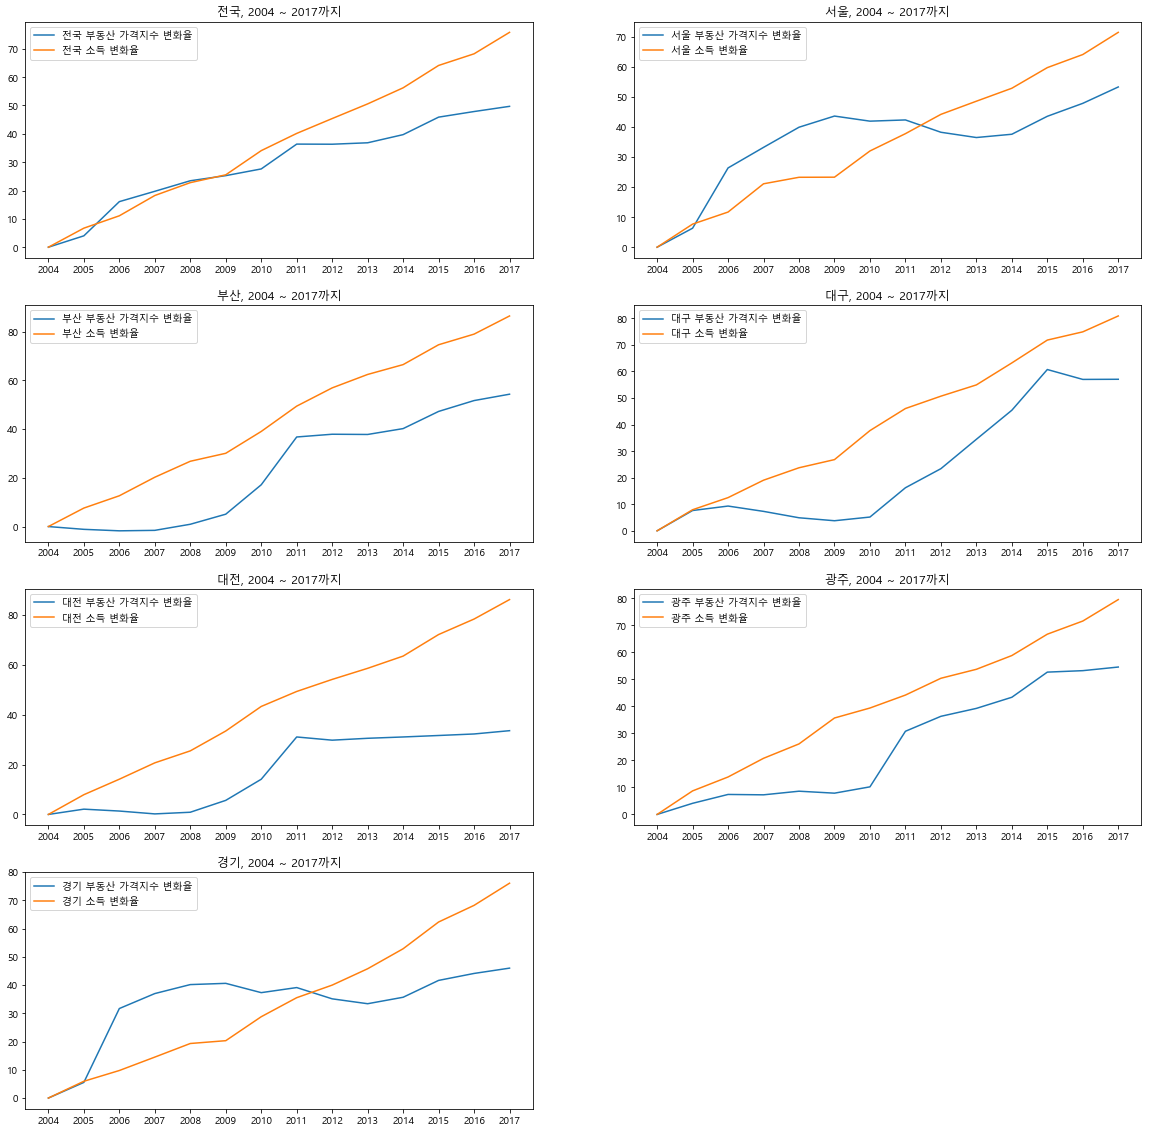

In [85]:
# 특정 지역의 개인소득/부동산 가격지수 변화 비교
location_list=['전국','서울','부산','대구','대전','광주','경기']
start_year='2004'
end_year='2017'

num_row=int((len(location_list)-1)/2)+1
plt.figure(figsize=(20,num_row*5))
for j,location in enumerate(location_list):
    year_data=[]
    for i in range(int(start_year),int(end_year)+1):
        if location=='제주':
            year_data.append(price_data[location]['서귀포'][str(i)+'.12.1'])
        else:
            year_data.append(price_data[location][location][str(i)+'.12.1'])
    temp_df=pd.DataFrame(income_data[location][start_year:])
    temp_df.columns=[location+'소득']
    temp_df[location+'부동산 가격지수']=year_data
    temp_df['소득 변화율']=(temp_df[location+'소득']/temp_df[location+'소득'][0]-1)*100
    temp_df['부동산 가격지수 변화율']=(temp_df[location+'부동산 가격지수']/temp_df[location+'부동산 가격지수'][0]-1)*100
    
    plt.subplot(num_row,2,j+1)
    plt.title(location+', '+start_year+' ~ '+end_year+'까지')
    plt.plot(temp_df['부동산 가격지수 변화율'],label=location+' 부동산 가격지수 변화율')
    plt.plot(temp_df['소득 변화율'],label=location+' 소득 변화율')
    plt.legend()